# EE541 Final Project
members: Yu-Hsin Wu, Yu-Hung Kung

USC-ID: 3434391900, 3431428440

email: , yuhungku@usc.edu

## Dataset
Extract and copy dataset from google drive to local path '/content/EE541_Final_Project'

### Mount google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!ls /content/drive/MyDrive/EE541_Final_Project/

asl_alphabet_test  asl_alphabet_train  dataset.zip  __MACOSX


### Extract dataset into local path

In [3]:
!mkdir EE541_Final_Project
!unzip /content/drive/MyDrive/EE541_Final_Project/dataset.zip -d /content/EE541_Final_Project

串流輸出內容已截斷至最後 5000 行。
  inflating: /content/EE541_Final_Project/asl_alphabet_train/asl_alphabet_train/W/W2815.jpg  
  inflating: /content/EE541_Final_Project/__MACOSX/asl_alphabet_train/asl_alphabet_train/W/._W2815.jpg  
  inflating: /content/EE541_Final_Project/asl_alphabet_train/asl_alphabet_train/W/W545.jpg  
  inflating: /content/EE541_Final_Project/__MACOSX/asl_alphabet_train/asl_alphabet_train/W/._W545.jpg  
  inflating: /content/EE541_Final_Project/asl_alphabet_train/asl_alphabet_train/W/W2801.jpg  
  inflating: /content/EE541_Final_Project/__MACOSX/asl_alphabet_train/asl_alphabet_train/W/._W2801.jpg  
  inflating: /content/EE541_Final_Project/asl_alphabet_train/asl_alphabet_train/W/W73.jpg  
  inflating: /content/EE541_Final_Project/__MACOSX/asl_alphabet_train/asl_alphabet_train/W/._W73.jpg  
  inflating: /content/EE541_Final_Project/asl_alphabet_train/asl_alphabet_train/W/W223.jpg  
  inflating: /content/EE541_Final_Project/__MACOSX/asl_alphabet_train/asl_alphabet_train/W/._W22

## Import packages

In [46]:
# import packages
import torch
import torch.nn as nn
import torchvision
import torchvision.utils as vutils
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
from torchvision.models import resnet34, resnet18, resnet50, mobilenet_v2
from sklearn.metrics import confusion_matrix, precision_recall_curve
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from tqdm import tqdm

In [5]:
# check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Dataset and Data Loader

in data_transforms, we can decide whether we want to apply any preprocessing to the training data. For instance, transforms.Grayscale() will transform the training data from RGB channel to Grayscale channel.

In [6]:
# Dataset and DataLoader
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.Grayscale(),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# load the full dataset
train_dataset = datasets.ImageFolder('/content/EE541_Final_Project/asl_alphabet_train/asl_alphabet_train', transform=data_transforms)
print(f"Dataset size: {len(train_dataset)}")
print(f"Class to index mapping: {train_dataset.class_to_idx}")

# split dataset into train, validation, test, three parts with proportion 70%, 15%, 15%
total_size = len(train_dataset)
train_size = int(total_size * 0.7)
val_size = int(total_size * 0.15)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(train_dataset, [train_size, val_size, test_size])

# set batch_size and initialize the data loader
batch_size = 256

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

Dataset size: 87000
Class to index mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}


## Print the training data.
We came up with the idea that there are left handed sign language users, we want to cover both hands. In order to reach this goal, we will have to flip the image horrizontally. The following is an example of using left and right hand to express sign language alphabet.

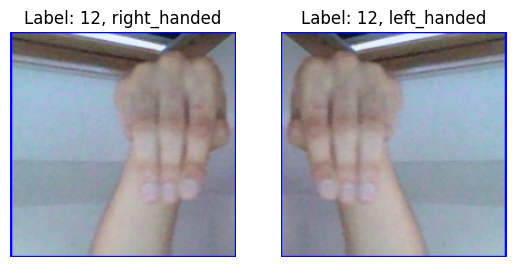

In [7]:
# Extract image and label
image, label = train_dataset[0]

# Convert tensor to a NumPy array
if image.ndimension() == 3:  # For RGB images (C, H, W)
    image = image.permute(1, 2, 0).numpy()  # Convert to (H, W, C)
else:  # For Grayscale images (H, W)
    image = image.numpy()

# If the image is normalized (e.g., in [0, 1] or [-1, 1]), adjust it to [0, 1] or [0, 255]
image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0, 1]
flipped_image = image[:, ::-1, :]



# Display using plt.imshow()
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray' if image.ndim == 2 else None)
plt.title(f"Label: {label}, right_handed")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(flipped_image, cmap='gray' if flipped_image.ndim == 2 else None)
plt.title(f"Label: {label}, left_handed")
plt.axis('off')
plt.savefig('handedness_comparison.jpg')
plt.show()


## Model Setup

In [7]:
# Model setup
num_classes = 29

# different model (resnet18, resnet34, resnet50, ...)
# model = resnet18(pretrained=True)
model = resnet34(pretrained=True)


model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)  # move the model to GPU

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 223MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Define the Training Function

In [7]:
def train_model(model, criterion, optimizer, learning_rate, unfreezing_epoch=10,num_epochs=20):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        scaler = torch.amp.GradScaler('cuda')

        # use tqdm to print the progress bar
        with tqdm(train_loader, desc=f"Training Epoch {epoch + 1}") as pbar:
            for inputs, labels in pbar:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                # forward and compute loss
                with torch.amp.autocast('cuda'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                # back propagation
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                # compute the accuracy
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                pbar.set_postfix(loss=loss.item(), accuracy=100. * correct / total)

        # train loss and accuracy of each epoch
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            with tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}") as pbar:
                for inputs, labels in pbar:
                    inputs, labels = inputs.to(device), labels.to(device)

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    _, predicted = outputs.max(1)
                    total += labels.size(0)
                    correct += predicted.eq(labels).sum().item()

                    pbar.set_postfix(loss=loss.item(), accuracy=100. * correct / total)

        val_loss /= len(val_loader)
        val_acc = 100. * correct / total

        # preserve loss and accuracy for plotting the learning curve
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        # unfreeze the layers
        if epoch == unfreezing_epoch - 1:
            for param in model.parameters():
                param.requires_grad = True
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
            print(f"Unfreezing all layers and reducing learning rate to {learning_rate}")

    return train_losses, val_losses, train_accs, val_accs

## Check Device
Check if CUDA is available.

In [9]:
!nvidia-smi

Mon Dec  9 08:27:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   43C    P0              18W /  72W |    299MiB / 23034MiB |      5%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Freeze all layer
Initially, we freeze all the parameters except for the fully-connected layer.

In [10]:
# Freeze all layers except the final fully connected layer
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

## Loss function and Optimizer

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4) # initial learning rate

## Start Training

In [11]:
# the learning rate that we use after unfreezing the parameters in epoch
lr = 1e-5

# at unfreezing_epoch, we will unfreeze the parameters and use the lr learing rate above
unfreezing_epoch = 10

# number of epoch
epoch = 16

# start training
train_losses, val_losses, train_accs, val_accs = train_model(model, criterion, optimizer, lr, unfreezing_epoch, epoch)

Validation Epoch 10: 100%|██████████| 26/26 [00:15<00:00,  1.66it/s, accuracy=85.9, loss=0.902]


Unfreezing all layers and reducing learning rate to 1e-05


Validation Epoch 16: 100%|██████████| 26/26 [00:15<00:00,  1.71it/s, accuracy=100, loss=0.0019]


## Plot learning curve

In [8]:
def plot_learning_curves(train_losses, val_losses, train_accs, val_accs):
  # Plot learning curves
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(train_losses, label='Train Loss')
  plt.plot(val_losses, label='Val Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.title('Loss Curves')

  plt.subplot(1, 2, 2)
  plt.plot(train_accs, label='Train Accuracy')
  plt.plot(val_accs, label='Val Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.title('Accuracy Curves')

  plt.tight_layout()
  plt.show()



In [ ]:
plot_learning_curves(train_losses, val_losses, train_accs, val_accs)

## Evaluate Model on Test set

In [9]:
def evaluate_model(model, test_loader, device, flip_rate=0.1):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    total_time = 0.0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            batch_size = inputs.size(0)

            # Horizontal flip with proportion flip_rate
            num_flip = int(batch_size * flip_rate)
            flip_indices = torch.randperm(batch_size)[:num_flip]
            inputs[flip_indices] = torch.flip(inputs[flip_indices], dims=[3])

            inputs, labels = inputs.to(device), labels.to(device)

            start = torch.cuda.Event(enable_timing=True)
            end = torch.cuda.Event(enable_timing=True)

            start.record()
            outputs = model(inputs)
            end.record()

            # Waits for everything to finish running
            torch.cuda.synchronize()

            # print(start.elapsed_time(end))
            total_time += float(start.elapsed_time(end))

            # start = time.time()
            # outputs = model(inputs)
            # end = time.time()

            # total_time += (end - start)
            total_samples += batch_size

            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    accuracy = 100 * np.mean(np.array(all_preds) == np.array(all_labels))
    avg_time = total_time / total_samples # in seconds

    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Average Execution Time per Sample: {avg_time * 1000:.6f} ms")

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)
# all_labels, all_preds, all_probs = evaluate_model_execution_time(model, test_loader, device, flip_rate=0.1)

### Test on right handed only testing set

In [24]:
# model = model.to(device)
flip = 0
all_labels, all_preds, all_probs = evaluate_model(model, test_loader, device, flip)
# torch.cuda.empty_cache()

Test Accuracy: 100.00%
Average Execution Time per Sample: 697.215084 ms


### Test on left handed only testing set

In [25]:
# torch.cuda.empty_cache()
flip = 1
all_labels, all_preds, all_probs = evaluate_model(model, test_loader, device, flip)
# torch.cuda.empty_cache()

Test Accuracy: 86.32%
Average Execution Time per Sample: 693.455758 ms


In [26]:
flip = 0.1
all_labels, all_preds, all_probs = evaluate_model(model, test_loader, device, flip)

Test Accuracy: 98.76%
Average Execution Time per Sample: 696.230396 ms


### Release GPU RAM after training

In [18]:
del model
del optimizer
torch.cuda.empty_cache()
torch.cuda.empty_cache()
!nvidia-smi

Mon Dec  9 02:05:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   71C    P0              34W /  72W |   1403MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Influence of right and left handed training data to model accuracy.
From the above outcomes, we can observe that the model can correctly classify between classes in right-handed only data. However, the model seems to have a lower accuracy (85.99%) on left-handed only data. This means that we need to apply data augmentation, increase the diversity of training data. For example, we can apply horizontal flip to training data.

## Try horizontal flip and rotation of training dataset.

### Define data loader.
In data_transforms, we apply resize, horizontal flip, rotation, and normalization.

In [10]:
# Dataset and DataLoader
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.Grayscale(),
    transforms.RandomHorizontalFlip(), # random horizontal flip with probability=0.5
    transforms.RandomRotation(10), #random rotation with [-10 degree, +10 degree]
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# load the full dataset
train_dataset = datasets.ImageFolder('/content/EE541_Final_Project/asl_alphabet_train/asl_alphabet_train', transform=data_transforms)
print(f"Dataset size: {len(train_dataset)}")
print(f"Class to index mapping: {train_dataset.class_to_idx}")

# split dataset into train, validation, test, three parts with proportion 70%, 15%, 15%
total_size = len(train_dataset)
train_size = int(total_size * 0.7)
val_size = int(total_size * 0.15)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(train_dataset, [train_size, val_size, test_size])

# set batch_size and initialize the data loader
batch_size = 256

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

Dataset size: 87000
Class to index mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}


### Model Setup

In [11]:
# Model setup
num_classes = 29

# different model (resnet18, resnet34, resnet50, ...)
# model = resnet18(pretrained=True)
model = resnet34(pretrained=True)


model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)  # move the model to GPU

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 214MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Freeze all layer

In [12]:
# Freeze all layers except the final fully connected layer
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

### Loss function and Optimizer

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4) # initial learning rate

### Start training

In [14]:
# the learning rate that we use after unfreezing the parameters in epoch
lr = 1e-5

# at unfreezing_epoch, we will unfreeze the parameters and use the lr learing rate above
unfreezing_epoch = 10

# number of epoch
epoch = 16

# start training
resnet34_train_losses, resnet34_val_losses, resnet34_train_accs, resnet34_val_accs = train_model(model, criterion, optimizer, lr, unfreezing_epoch, epoch)

Validation Epoch 10: 100%|██████████| 51/51 [00:14<00:00,  3.54it/s, accuracy=78.8, loss=1.08]


Unfreezing all layers and reducing learning rate to 1e-05


Validation Epoch 16: 100%|██████████| 51/51 [00:14<00:00,  3.46it/s, accuracy=100, loss=0.000994]


### Plot learning curve

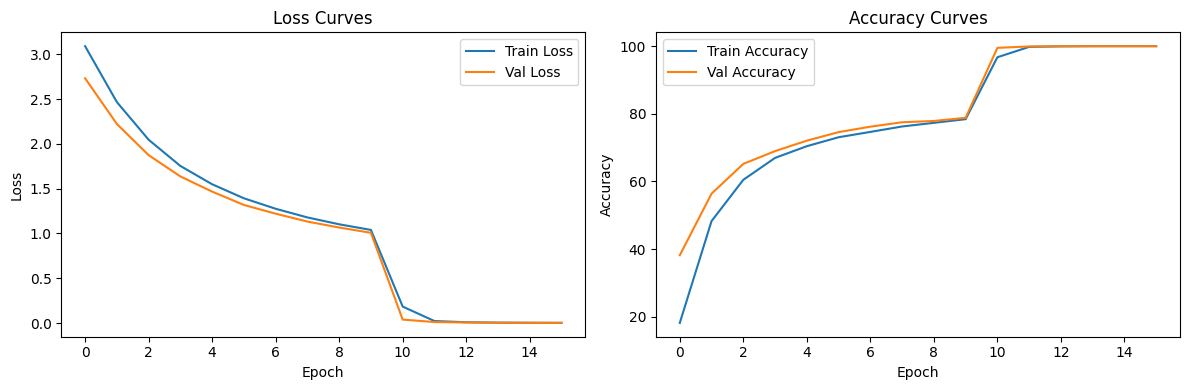

In [15]:
plot_learning_curves(resnet34_train_losses, resnet34_val_losses, resnet34_train_accs, resnet34_val_accs)

### Evaluate model on test datset

In [16]:
model = model.to(device)
flip = 0
all_labels, all_preds, all_probs = evaluate_model(model, test_loader, device, flip)

Test Accuracy: 100.00%
Average Execution Time per Sample: 683.661718 ms


In [17]:
flip = 1
all_labels, all_preds, all_probs = evaluate_model(model, test_loader, device, flip)

Test Accuracy: 99.98%
Average Execution Time per Sample: 684.843598 ms


In [18]:
flip = 0.1
all_labels, all_preds, all_probs = evaluate_model(model, test_loader, device, flip)

Test Accuracy: 100.00%
Average Execution Time per Sample: 685.215809 ms


### Release GPU RAM

In [19]:
del model
del optimizer
torch.cuda.empty_cache()
torch.cuda.empty_cache()
!nvidia-smi

Mon Dec  9 11:21:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   76C    P0              59W /  72W |    913MiB / 23034MiB |     86%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Try transforming training data into grayscale

### Define data loader

In [38]:
# Dataset and DataLoader
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(), # random horizontal flip with probability=0.5
    transforms.RandomRotation(10), #random rotation with [-10 degree, +10 degree]
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    transforms.Normalize([0.5], [0.5]),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)) # need to be 3 channels, even if it's grayscalse
])

# load the full dataset
train_dataset = datasets.ImageFolder('/content/EE541_Final_Project/asl_alphabet_train/asl_alphabet_train', transform=data_transforms)
print(f"Dataset size: {len(train_dataset)}")
print(f"Class to index mapping: {train_dataset.class_to_idx}")

# split dataset into train, validation, test, three parts with proportion 70%, 15%, 15%
total_size = len(train_dataset)
train_size = int(total_size * 0.7)
val_size = int(total_size * 0.15)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(train_dataset, [train_size, val_size, test_size])

# set batch_size and initialize the data loader
batch_size = 512

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

Dataset size: 87000
Class to index mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}


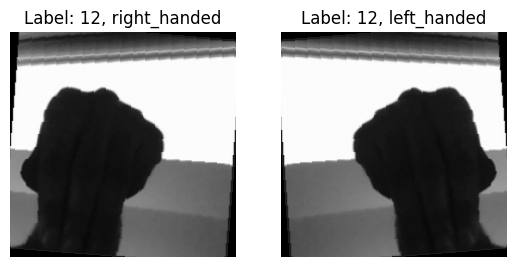

In [39]:
# Extract image and label
image, label = train_dataset[0]

# Convert tensor to a NumPy array
if image.ndimension() == 3:  # For RGB images (C, H, W)
    image = image.permute(1, 2, 0).numpy()  # Convert to (H, W, C)
else:  # For Grayscale images (H, W)
    image = image.numpy()

# If the image is normalized (e.g., in [0, 1] or [-1, 1]), adjust it to [0, 1] or [0, 255]
image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0, 1]
flipped_image = image[:, ::-1, :]



# Display using plt.imshow()
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray' if image.ndim == 2 else None)
plt.title(f"Label: {label}, right_handed")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(flipped_image, cmap='gray' if flipped_image.ndim == 2 else None)
plt.title(f"Label: {label}, left_handed")
plt.axis('off')
plt.savefig('handedness_comparison.jpg')
plt.show()

### Model Setup

In [40]:
# Model setup
num_classes = 29

# different model (resnet18, resnet34, resnet50, ...)
# model = resnet18(pretrained=True)
model = resnet34(pretrained=True)


model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)  # move the model to GPU

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Freeze a all layer

In [41]:
# Freeze all layers except the final fully connected layer
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

### Loss Function and Optimizer

In [42]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4) # initial learning rate

### Start training

In [43]:
# the learning rate that we use after unfreezing the parameters in epoch
lr = 1e-5

# at unfreezing_epoch, we will unfreeze the parameters and use the lr learing rate above
unfreezing_epoch = 10

# number of epoch
epoch = 16

# start training
train_losses, val_losses, train_accs, val_accs = train_model(model, criterion, optimizer, lr, unfreezing_epoch, epoch)

Validation Epoch 10: 100%|██████████| 26/26 [00:15<00:00,  1.68it/s, accuracy=68.5, loss=1.49]


Unfreezing all layers and reducing learning rate to 1e-05


Validation Epoch 16: 100%|██████████| 26/26 [00:15<00:00,  1.67it/s, accuracy=99.9, loss=0.00618]


### Plot learning curve

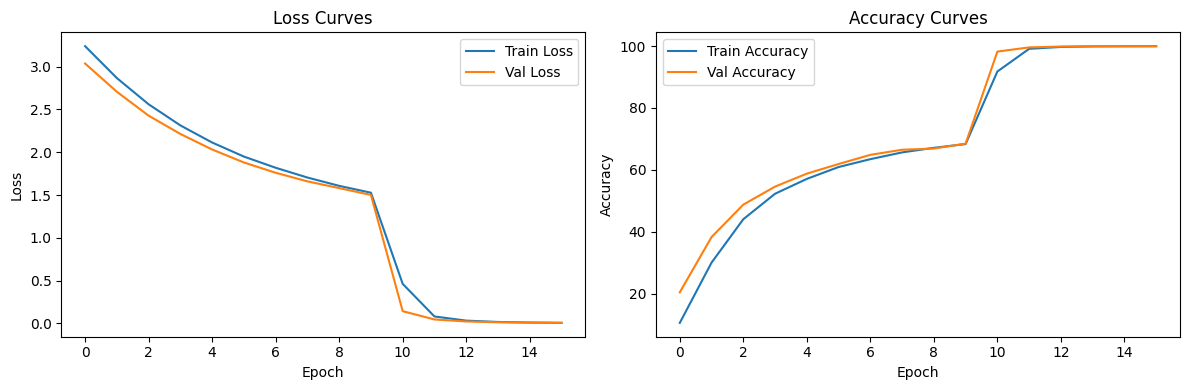

In [44]:
plot_learning_curves(train_losses, val_losses, train_accs, val_accs)

### Evaluate model on test dataset

In [45]:
flip = 0
all_labels, all_preds, all_probs = evaluate_model(model, test_loader, device, flip)

Test Accuracy: 99.95%
Average Execution Time per Sample: 693.066355 ms


In [46]:
flip = 1
all_labels, all_preds, all_probs = evaluate_model(model, test_loader, device, flip)

Test Accuracy: 99.96%
Average Execution Time per Sample: 695.151473 ms


In [47]:
flip = 0.1
all_labels, all_preds, all_probs = evaluate_model(model, test_loader, device, flip)

Test Accuracy: 99.95%
Average Execution Time per Sample: 692.537066 ms


### Release GPU RAM after training

In [53]:
del model
del optimizer
torch.cuda.empty_cache()
torch.cuda.empty_cache()
!nvidia-smi


Mon Dec  9 03:05:05 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   76C    P0              35W /  72W |   3131MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## ResNet18

### Data Loader

In [20]:
# Dataset and DataLoader
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.Grayscale(),
    transforms.RandomHorizontalFlip(), # random horizontal flip with probability=0.5
    transforms.RandomRotation(10), #random rotation with [-10 degree, +10 degree]
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# load the full dataset
train_dataset = datasets.ImageFolder('/content/EE541_Final_Project/asl_alphabet_train/asl_alphabet_train', transform=data_transforms)
print(f"Dataset size: {len(train_dataset)}")
print(f"Class to index mapping: {train_dataset.class_to_idx}")

# split dataset into train, validation, test, three parts with proportion 70%, 15%, 15%
total_size = len(train_dataset)
train_size = int(total_size * 0.7)
val_size = int(total_size * 0.15)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(train_dataset, [train_size, val_size, test_size])

# set batch_size and initialize the data loader
batch_size = 512

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

Dataset size: 87000
Class to index mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}


### Model Setup

In [21]:
# Model setup
num_classes = 29

# different model (resnet18, resnet34, resnet50, ...)
# model = resnet18(pretrained=True)
model = resnet18(pretrained=True)


model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)  # move the model to GPU

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 224MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Freeze all layer

In [22]:
# Freeze all layers except the final fully connected layer
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

### Loss Funciton and optimizer

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4) # initial learning rate

### Start Training

In [24]:
# the learning rate that we use after unfreezing the parameters in epoch
lr = 1e-5

# at unfreezing_epoch, we will unfreeze the parameters and use the lr learing rate above
unfreezing_epoch = 10

# number of epoch
epoch = 16

# start training
resnet18_train_losses, resnet18_val_losses, resnet18_train_accs, resnet18_val_accs = train_model(model, criterion, optimizer, lr, unfreezing_epoch, epoch)

Validation Epoch 10: 100%|██████████| 26/26 [00:11<00:00,  2.17it/s, accuracy=75.8, loss=1.35]


Unfreezing all layers and reducing learning rate to 1e-05


Validation Epoch 16: 100%|██████████| 26/26 [00:12<00:00,  2.14it/s, accuracy=99.9, loss=0.0155]


### Plot Learning Curve

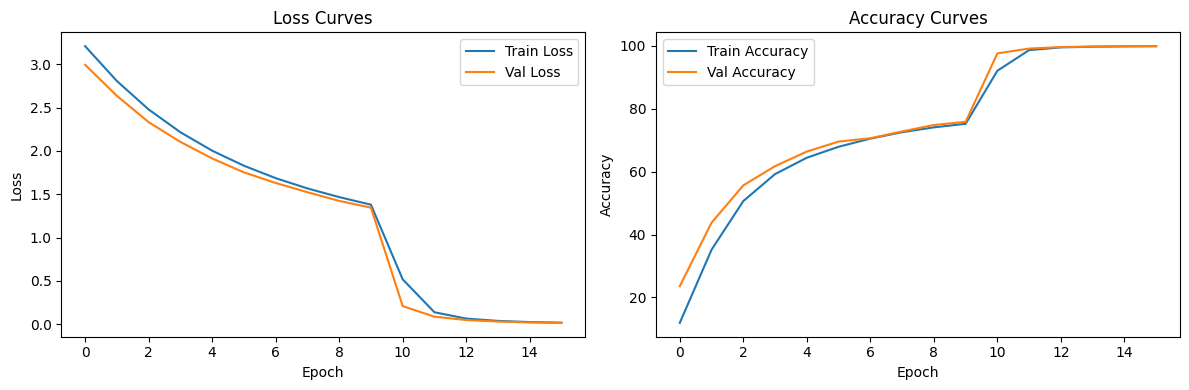

In [25]:
plot_learning_curves(resnet18_train_losses, resnet18_val_losses, resnet18_train_accs, resnet18_val_accs)

### Evaluate model on test dataset

In [26]:
model = model.to(device)
flip = 0
all_labels, all_preds, all_probs = evaluate_model(model, test_loader, device, flip)

Test Accuracy: 99.88%
Average Execution Time per Sample: 421.940791 ms


In [27]:
flip = 1
all_labels, all_preds, all_probs = evaluate_model(model, test_loader, device, flip)

Test Accuracy: 99.92%
Average Execution Time per Sample: 422.773591 ms


In [28]:
flip = 0.1
all_labels, all_preds, all_probs = evaluate_model(model, test_loader, device, flip)

Test Accuracy: 99.92%
Average Execution Time per Sample: 423.685791 ms


### Release GPU RAM after training

In [29]:
del model
del optimizer
torch.cuda.empty_cache()
torch.cuda.empty_cache()
!nvidia-smi

Mon Dec  9 11:39:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   77C    P0              54W /  72W |   1167MiB / 23034MiB |     52%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## ResNet50

### Data Loader

In [30]:
# Dataset and DataLoader
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.Grayscale(),
    transforms.RandomHorizontalFlip(), # random horizontal flip with probability=0.5
    transforms.RandomRotation(10), #random rotation with [-10 degree, +10 degree]
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# load the full dataset
train_dataset = datasets.ImageFolder('/content/EE541_Final_Project/asl_alphabet_train/asl_alphabet_train', transform=data_transforms)
print(f"Dataset size: {len(train_dataset)}")
print(f"Class to index mapping: {train_dataset.class_to_idx}")

# split dataset into train, validation, test, three parts with proportion 70%, 15%, 15%
total_size = len(train_dataset)
train_size = int(total_size * 0.7)
val_size = int(total_size * 0.15)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(train_dataset, [train_size, val_size, test_size])

# set batch_size and initialize the data loader
batch_size = 256

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

Dataset size: 87000
Class to index mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}


### Model Setup

In [31]:
# Model setup
num_classes = 29

# different model (resnet18, resnet34, resnet50, ...)
# model = resnet18(pretrained=True)
model = resnet50(pretrained=True)


model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)  # move the model to GPU

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 209MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Freeze all layer

In [32]:
# Freeze all layers except the final fully connected layer
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

### Loss function and optimizer

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4) # initial learning rate

### Start training

In [34]:
# the learning rate that we use after unfreezing the parameters in epoch
lr = 1e-5

# at unfreezing_epoch, we will unfreeze the parameters and use the lr learing rate above
unfreezing_epoch = 10

# number of epoch
epoch = 16

# start training
resnet50_train_losses, resnet50_val_losses, resnet50_train_accs, resnet50_val_accs = train_model(model, criterion, optimizer, lr, unfreezing_epoch, epoch)

Validation Epoch 10: 100%|██████████| 51/51 [00:26<00:00,  1.95it/s, accuracy=82.1, loss=0.803]


Unfreezing all layers and reducing learning rate to 1e-05


Validation Epoch 16: 100%|██████████| 51/51 [00:25<00:00,  1.99it/s, accuracy=100, loss=0.000623]


### Plot learning curve

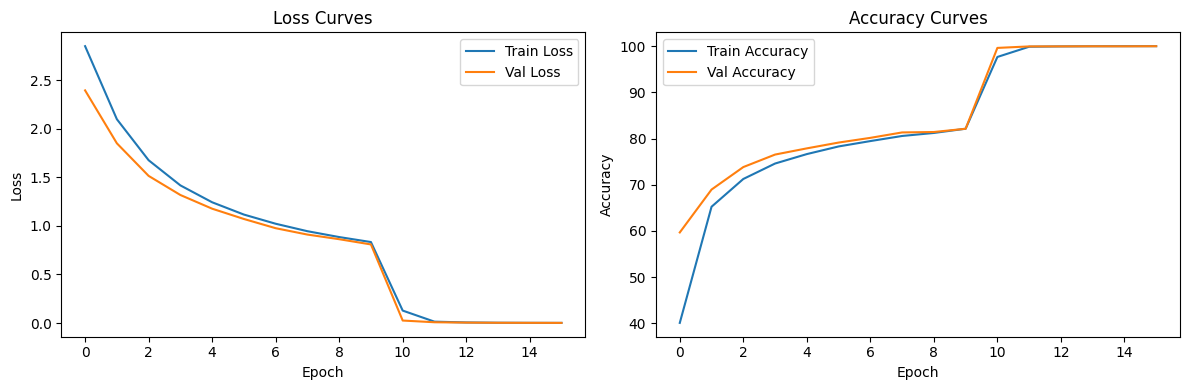

In [35]:
plot_learning_curves(resnet50_train_losses, resnet50_val_losses, resnet50_train_accs, resnet50_val_accs)

### Evaluate model on test dataset

In [36]:
model = model.to(device)
flip = 0
all_labels, all_preds, all_probs = evaluate_model(model, test_loader, device, flip)

Test Accuracy: 100.00%
Average Execution Time per Sample: 1556.694736 ms


In [37]:
flip = 1
all_labels, all_preds, all_probs = evaluate_model(model, test_loader, device, flip)

Test Accuracy: 99.98%
Average Execution Time per Sample: 1556.471751 ms


In [38]:
flip = 0.1
all_labels, all_preds, all_probs = evaluate_model(model, test_loader, device, flip)

Test Accuracy: 100.00%
Average Execution Time per Sample: 1556.850175 ms


### Release GPU RAM after training

In [39]:
del model
del optimizer
torch.cuda.empty_cache()
torch.cuda.empty_cache()
!nvidia-smi

Mon Dec  9 12:18:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   75C    P0              66W /  72W |   1903MiB / 23034MiB |     39%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## MobileNetV2

### Data loader

In [76]:
# Dataset and DataLoader
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.Grayscale(),
    transforms.RandomHorizontalFlip(), # random horizontal flip with probability=0.5
    transforms.RandomRotation(10), #random rotation with [-10 degree, +10 degree]
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# load the full dataset
train_dataset = datasets.ImageFolder('/content/EE541_Final_Project/asl_alphabet_train/asl_alphabet_train', transform=data_transforms)
print(f"Dataset size: {len(train_dataset)}")
print(f"Class to index mapping: {train_dataset.class_to_idx}")

# split dataset into train, validation, test, three parts with proportion 70%, 15%, 15%
total_size = len(train_dataset)
train_size = int(total_size * 0.7)
val_size = int(total_size * 0.15)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(train_dataset, [train_size, val_size, test_size])

# set batch_size and initialize the data loader
batch_size = 256

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

Dataset size: 87000
Class to index mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}


### Model Setup

In [77]:
# Model setup
num_classes = 29  # Number of output classes

# Load pretrained MobileNetV2 model
model = mobilenet_v2(weights="IMAGENET1K_V1")  # Use pretrained weights

# Modify the classifier to match the number of classes
model.classifier[1] = nn.Linear(model.last_channel, num_classes)  # Replace the final layer

# Move the model to GPU (if available)
model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

### Freeze all layer

In [78]:
# Freeze all layers except the final fully connected layer
for param in model.parameters():
    param.requires_grad = True

# for param in model.fc.parameters():
#     param.requires_grad = True

### Loss function and optimizer

In [79]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4) # initial learning rate

### Define Training function for MobileNet

In [80]:
def train_model(model, criterion, optimizer, train_loader, val_loader, device, learning_rate=1e-3, unfreezing_epoch=10, num_epochs=20):
    """
    Train and validate a PyTorch model.

    Parameters:
        model (torch.nn.Module): The model to train.
        criterion (torch.nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer for training.
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        device (torch.device): Device to train on ('cuda' or 'cpu').
        learning_rate (float): Learning rate after unfreezing layers.
        unfreezing_epoch (int): Epoch at which to unfreeze all layers.
        num_epochs (int): Total number of epochs.

    Returns:
        train_losses (list): Training losses for each epoch.
        val_losses (list): Validation losses for each epoch.
        train_accs (list): Training accuracies for each epoch.
        val_accs (list): Validation accuracies for each epoch.
    """
    # Initialize lists to store losses and accuracies
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    # Mixed precision scaler
    scaler = torch.cuda.amp.GradScaler()

    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        with tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{num_epochs}") as pbar:
            for inputs, labels in pbar:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                # Forward pass with mixed precision
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                # Backward pass with gradient scaling
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                # Update metrics
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                # Update progress bar
                pbar.set_postfix(loss=loss.item(), accuracy=100. * correct / total)

        # Calculate training loss and accuracy for the epoch
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            with tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{num_epochs}") as pbar:
                for inputs, labels in pbar:
                    inputs, labels = inputs.to(device), labels.to(device)

                    # Forward pass
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # Update metrics
                    val_loss += loss.item()
                    _, predicted = outputs.max(1)
                    total += labels.size(0)
                    correct += predicted.eq(labels).sum().item()

                    # Update progress bar
                    pbar.set_postfix(loss=loss.item(), accuracy=100. * correct / total)

        # Calculate validation loss and accuracy for the epoch
        val_loss /= len(val_loader)
        val_acc = 100. * correct / total

        # Store losses and accuracies for plotting later
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch + 1}/{num_epochs} -> Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Unfreeze layers at the specified epoch
        # if epoch == unfreezing_epoch - 1:
        #     print(f"Unfreezing all layers at epoch {epoch + 1}")
        #     for param in model.parameters():
        #         param.requires_grad = True

        #     optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Update optimizer with new learning rate

    return train_losses, val_losses, train_accs, val_accs


### Start training

In [81]:
# the learning rate that we use after unfreezing the parameters in epoch
lr = 1e-5

# at unfreezing_epoch, we will unfreeze the parameters and use the lr learing rate above
unfreezing_epoch = 10

# number of epoch
epoch = 16

# start training
mobilenetv2_train_losses, mobilenetv2_val_losses, mobilenetv2_train_accs, mobilenetv2_val_accs = train_model(model, criterion, optimizer, train_loader, val_loader, device, lr, unfreezing_epoch, epoch)

<ipython-input-80-0894fca369b4>:27: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Training Epoch 1/16:   0%|          | 0/238 [00:00<?, ?it/s]<ipython-input-80-0894fca369b4>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation Epoch 1/16: 100%|██████████| 51/51 [00:14<00:00,  3.44it/s, accuracy=99.8, loss=0.0167]


Epoch 1/16 -> Train Loss: 0.4999, Train Acc: 91.34%, Val Loss: 0.0176, Val Acc: 99.85%


Validation Epoch 2/16: 100%|██████████| 51/51 [00:14<00:00,  3.44it/s, accuracy=100, loss=0.0045]


Epoch 2/16 -> Train Loss: 0.0105, Train Acc: 99.94%, Val Loss: 0.0052, Val Acc: 99.96%


Validation Epoch 3/16: 100%|██████████| 51/51 [00:14<00:00,  3.48it/s, accuracy=100, loss=0.00487]


Epoch 3/16 -> Train Loss: 0.0038, Train Acc: 99.98%, Val Loss: 0.0025, Val Acc: 99.98%


Validation Epoch 4/16: 100%|██████████| 51/51 [00:14<00:00,  3.44it/s, accuracy=100, loss=0.00189]


Epoch 4/16 -> Train Loss: 0.0022, Train Acc: 99.99%, Val Loss: 0.0011, Val Acc: 100.00%


Validation Epoch 5/16: 100%|██████████| 51/51 [00:14<00:00,  3.44it/s, accuracy=100, loss=0.00169]


Epoch 5/16 -> Train Loss: 0.0013, Train Acc: 100.00%, Val Loss: 0.0009, Val Acc: 99.99%


Validation Epoch 6/16: 100%|██████████| 51/51 [00:14<00:00,  3.46it/s, accuracy=100, loss=0.00053]


Epoch 6/16 -> Train Loss: 0.0008, Train Acc: 100.00%, Val Loss: 0.0007, Val Acc: 99.99%


Validation Epoch 7/16: 100%|██████████| 51/51 [00:14<00:00,  3.45it/s, accuracy=99.9, loss=0.00501]


Epoch 7/16 -> Train Loss: 0.0039, Train Acc: 99.92%, Val Loss: 0.0038, Val Acc: 99.89%


Validation Epoch 8/16: 100%|██████████| 51/51 [00:14<00:00,  3.50it/s, accuracy=100, loss=0.00285]


Epoch 8/16 -> Train Loss: 0.0019, Train Acc: 99.96%, Val Loss: 0.0012, Val Acc: 99.97%


Validation Epoch 9/16: 100%|██████████| 51/51 [00:14<00:00,  3.44it/s, accuracy=100, loss=0.000636]


Epoch 9/16 -> Train Loss: 0.0014, Train Acc: 99.97%, Val Loss: 0.0010, Val Acc: 99.98%


Validation Epoch 10/16: 100%|██████████| 51/51 [00:14<00:00,  3.41it/s, accuracy=100, loss=0.000369]


Epoch 10/16 -> Train Loss: 0.0007, Train Acc: 99.99%, Val Loss: 0.0003, Val Acc: 99.99%


Validation Epoch 11/16: 100%|██████████| 51/51 [00:14<00:00,  3.45it/s, accuracy=100, loss=0.000284]


Epoch 11/16 -> Train Loss: 0.0003, Train Acc: 100.00%, Val Loss: 0.0011, Val Acc: 99.98%


Validation Epoch 12/16: 100%|██████████| 51/51 [00:14<00:00,  3.51it/s, accuracy=100, loss=0.000103]


Epoch 12/16 -> Train Loss: 0.0002, Train Acc: 100.00%, Val Loss: 0.0001, Val Acc: 100.00%


Validation Epoch 13/16: 100%|██████████| 51/51 [00:14<00:00,  3.45it/s, accuracy=100, loss=0.000188]


Epoch 13/16 -> Train Loss: 0.0001, Train Acc: 100.00%, Val Loss: 0.0001, Val Acc: 100.00%


Validation Epoch 14/16: 100%|██████████| 51/51 [00:14<00:00,  3.43it/s, accuracy=100, loss=0.000106]


Epoch 14/16 -> Train Loss: 0.0001, Train Acc: 100.00%, Val Loss: 0.0001, Val Acc: 100.00%


Validation Epoch 15/16: 100%|██████████| 51/51 [00:14<00:00,  3.51it/s, accuracy=100, loss=0.000149]


Epoch 15/16 -> Train Loss: 0.0001, Train Acc: 100.00%, Val Loss: 0.0001, Val Acc: 100.00%


Validation Epoch 16/16: 100%|██████████| 51/51 [00:14<00:00,  3.50it/s, accuracy=99.8, loss=0.0198]

Epoch 16/16 -> Train Loss: 0.0011, Train Acc: 99.97%, Val Loss: 0.0065, Val Acc: 99.82%


### Plot learning curve

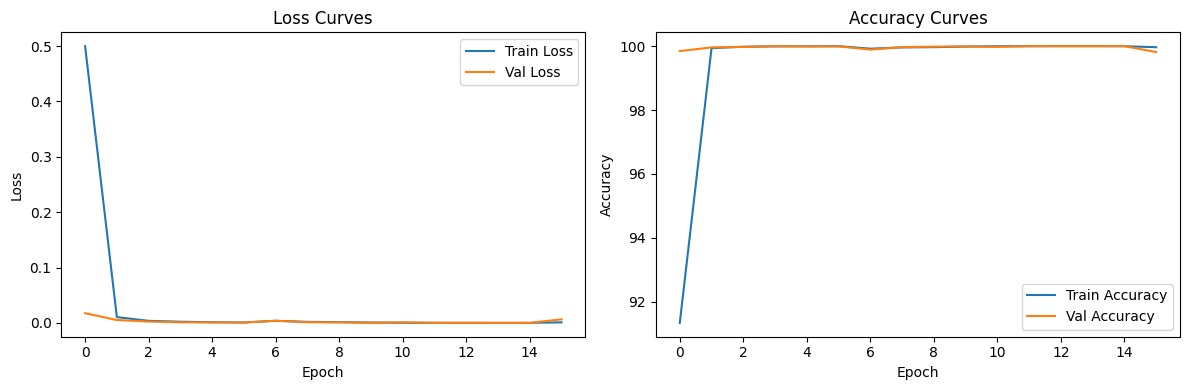

In [82]:
plot_learning_curves(mobilenetv2_train_losses, mobilenetv2_val_losses, mobilenetv2_train_accs, mobilenetv2_val_accs)

### Evaluate model on test dataset

In [83]:
model = model.to(device)
flip = 0
all_labels, all_preds, all_probs = evaluate_model(model, test_loader, device, flip)

Test Accuracy: 99.86%
Average Execution Time per Sample: 671.739354 ms


In [84]:
flip = 1
all_labels, all_preds, all_probs = evaluate_model(model, test_loader, device, flip)

Test Accuracy: 99.86%
Average Execution Time per Sample: 671.570059 ms


In [85]:
flip = 0.1
all_labels, all_preds, all_probs = evaluate_model(model, test_loader, device, flip)

Test Accuracy: 99.85%
Average Execution Time per Sample: 671.405501 ms


### Release GPU RAM after training

In [86]:
del model
del optimizer
torch.cuda.empty_cache()
torch.cuda.empty_cache()
!nvidia-smi

Mon Dec  9 13:32:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   66C    P0              61W /  72W |   3239MiB / 23034MiB |     48%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Summary
compare 4 different models with their loss curves, accuracy curves, and execution time.

In [91]:
def plot_loss_curves(resnet18_train_loss, resnet34_train_loss, resnet50_train_loss, mobilenetv2_train_loss):
    epochs = range(1, len(resnet18_train_loss) + 1)  # Assuming all models have the same number of epochs

    # Plot loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, resnet18_train_loss, label='ResNet18', marker='o')
    plt.plot(epochs, resnet34_train_loss, label='ResNet34', marker='s')
    plt.plot(epochs, resnet50_train_loss, label='ResNet50', marker='^')
    plt.plot(epochs, mobilenetv2_train_loss, label='MobileNetV2', marker='d')

    # Add labels, title, and legend
    plt.title('Training Loss Curves for Different Models', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    # Show the plot
    plt.savefig('Loss_curves_comparison.jpg')
    plt.show()

def plot_accuracy_curves(resnet18_train_acc, resnet34_train_acc, resnet50_train_acc, mobilenetv2_train_acc):
    epochs = range(1, len(resnet18_train_acc) + 1)  # Assuming all models have the same number of epochs

    # Plot loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, resnet18_train_acc, label='ResNet18', marker='o')
    plt.plot(epochs, resnet34_train_acc, label='ResNet34', marker='s')
    plt.plot(epochs, resnet50_train_acc, label='ResNet50', marker='^')
    plt.plot(epochs, mobilenetv2_train_acc, label='MobileNetV2', marker='d')

    # Add labels, title, and legend
    plt.title('Training Accuracy Curves for Different Models', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    # Show the plot
    plt.savefig('Accuracy_curves_comparison.jpg')
    plt.show()

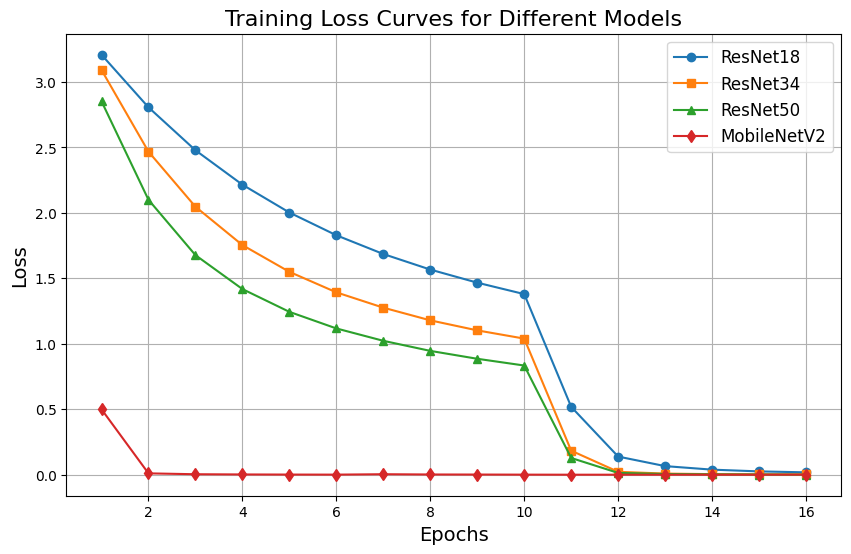

In [88]:
plot_loss_curves(resnet18_train_losses, resnet34_train_losses, resnet50_train_losses, mobilenetv2_train_losses)

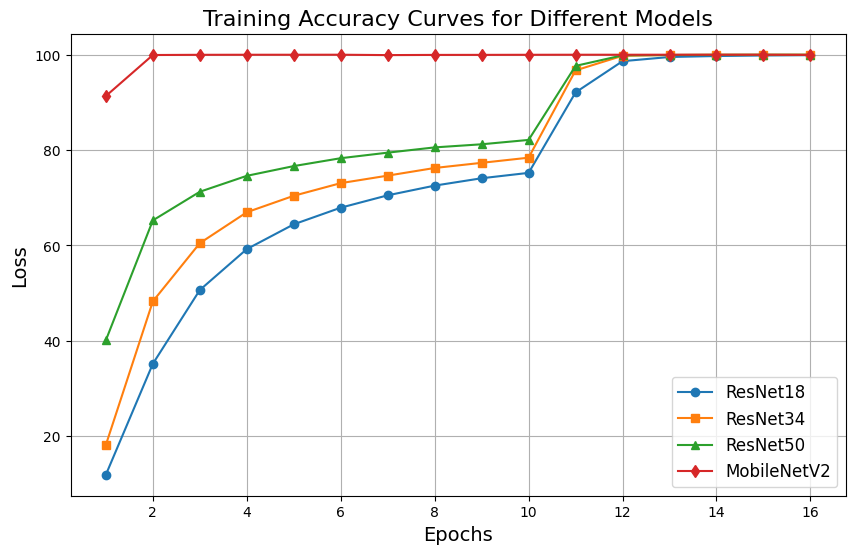

In [94]:
plot_accuracy_curves(resnet18_train_accs, resnet34_train_accs, resnet50_train_accs, mobilenetv2_train_accs)

In [113]:
def merge_plots(resnet18_train_loss, resnet34_train_loss, resnet50_train_loss, mobilenetv2_train_loss, resnet18_train_acc, resnet34_train_acc, resnet50_train_acc, mobilenetv2_train_acc):
  epochs = range(1, len(resnet18_train_loss) + 1)  # Assuming all models have the same number of epochs

  plt.figure(figsize=(20, 10))
  plt.subplot(1, 2, 1)

  # Plot loss curves
  # plt.figure(figsize=(10, 6))
  plt.plot(epochs, resnet18_train_loss, label='ResNet18', marker='o')
  plt.plot(epochs, resnet34_train_loss, label='ResNet34', marker='s')
  plt.plot(epochs, resnet50_train_loss, label='ResNet50', marker='^')
  plt.plot(epochs, mobilenetv2_train_loss, label='MobileNetV2', marker='d')

  # Add labels, title, and legend
  plt.title('Training Loss Curves for Different Models', fontsize=14)
  plt.xlabel('Epochs', fontsize=12)
  plt.ylabel('Loss', fontsize=12)
  plt.legend(fontsize=12)
  plt.grid(True)

  plt.subplot(1, 2, 2)
  # Plot loss curves
  # plt.figure(figsize=(10, 6))
  plt.plot(epochs, resnet18_train_acc, label='ResNet18', marker='o')
  plt.plot(epochs, resnet34_train_acc, label='ResNet34', marker='s')
  plt.plot(epochs, resnet50_train_acc, label='ResNet50', marker='^')
  plt.plot(epochs, mobilenetv2_train_acc, label='MobileNetV2', marker='d')

  # Add labels, title, and legend
  plt.title('Training Accuracy Curves for Different Models', fontsize=14)
  plt.xlabel('Epochs', fontsize=12)
  plt.ylabel('Loss', fontsize=12)
  plt.legend(fontsize=12)
  plt.grid(True)

  # Show the plot
  plt.savefig('Loss_Accuracy.jpg')
  plt.show()

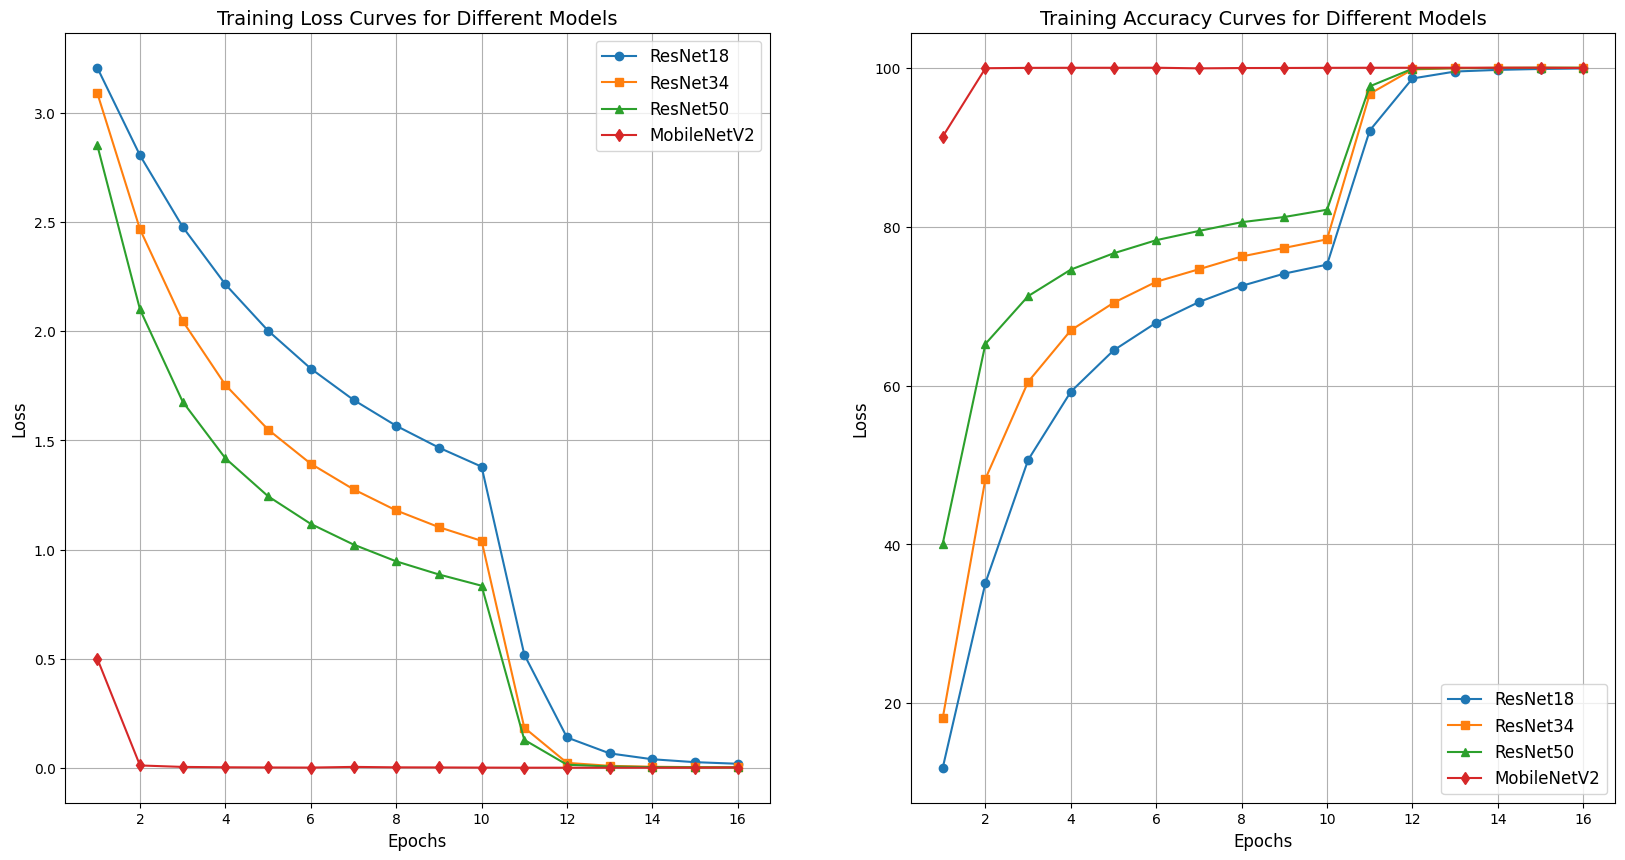

In [114]:
merge_plots(resnet18_train_losses, resnet34_train_losses, resnet50_train_losses, mobilenetv2_train_losses, resnet18_train_accs, resnet34_train_accs, resnet50_train_accs, mobilenetv2_train_accs)